# Grover’s Algorithm and the Molecular Distance Geometry Problem


This is the code that goes along with the presentation for ES 170, Spring 2020. 

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=np.inf)

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from IPython.display import Latex

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

## Classical Molecule Functions

Here are functions for manipulating molecules in the context of classical computing

In [0]:
class Classical_Molecule():
    '''All the methods needed to manipulate a molecule with classical programming'''
    def __init__(self, distances, bondangle):
        self.distances = distances
        self.bondangle = bondangle
        self.torcos_cache = [None for _ in range(len(distances))]
        self.B_cache = [[None for _ in range(2)] for _ in range(len(distances))]

    def dist(cls, a, b):
        '''distance between points a and b'''
        return np.sqrt(np.sum(np.square(a-b)))

    def distance_mat(cls, locs):
        '''creates a distance matrix from a list of coordinates'''
        dm = [[cls.dist(locs[a], locs[b]) for a in range(len(locs))] for b in range(len(locs))]
        dm = np.array(dm)
        return dm

    def angle(cls, a,b,c):
        #calculates the angle between a,b,c
        ab = a - b
        bc = c - b
        dot = ab @ bc
        dot /= np.sqrt(ab @ ab) * np.sqrt(bc @ bc)
        angle = np.arccos(dot)
        return angle

    def rotate_plane(cls, a, b, axis):
        '''returns the matrix of rotating point b around axis (0=x, 1=y,2=z) so that it corresponds to a '''
        x = a 
        y = b
        x[axis] = 0
        y[axis] = 0
        dot = x @ y
        dot /= np.sqrt(x @ x) * np.sqrt(y @ y)
        angle = -np.arccos(dot)
        
        rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        rot = np.insert(rot, axis, axis=0, values=0)
        rot = np.insert(rot, axis, axis=1, values=0)
        rot[axis][axis] = 1

        return rot

    def torcos(self, i):
        '''calculates the cosine of the torsion angle from atoms i,i+1,i+2, i+3'''
        if self.torcos_cache[i] is not None:
            return self.torcos_cache[i]
        
        j = i+1
        k = i+2
        l = i+3
        r = self.distances
        cos = r[i][j]**2 +r[j][l]**2- r[i][j]/r[j][k] * (r[j][l]**2 +r[j][k]**2-r[k][l]**2)*np.cos(self.bondangle[i]) - r[i][l]**2
        cos /= r[i][j]/r[j][k] * np.sqrt(4*r[j][l]**2*r[j][k]**2-(r[j][l]**2+r[j][k]**2-r[k][l]**2)**2) * np.sin(self.bondangle[i])
        self.torcos_cache[i] = cos
        return cos

    def torsin(self, i, sign):
        assert sign in [1,-1]
        return sign * np.sqrt(1-self.torcos(i)**2)

    def Bmat(self, i, sign):
        '''calculates the B matrix from the paper'''
        assert sign in [1,0,-1]
        signind = (sign+1)//2
        if self.B_cache[i][signind] is not None:
            return self.B_cache[i][signind]
        
        r = self.distances
        t = self.bondangle
        
        if i == 0:
            res = np.eye(4)
        elif i == 1:
            res = np.array([[-1,0,0,-r[0][1]], [0,1,0,0], [0,0,-1,0],[0,0,0,1]])
        elif i == 2:
            res = np.array([[-np.cos(t[0]), -np.sin(t[0]), 0, -r[1][2]*np.cos(t[0])], 
                            [ np.sin(t[0]), -np.cos(t[0]), 0,  r[1][2]*np.sin(t[0])],
                            [0,0,1,0],[0,0,0,1]])
        else:
            res = np.array([[-np.cos(t[i-2]), -np.sin(t[i-2]), 0, -r[i-1][i]*np.cos(t[i-2])],
                        [np.sin(t[i-2])*self.torcos(i-3), -np.cos(t[i-2])*self.torcos(i-3), -self.torsin(i-3, sign), r[i-1][i]*np.sin(t[i-2])*self.torcos(i-3)],
                        [np.sin(t[i-2])*self.torsin(i-3, sign), -np.cos(t[i-2])*self.torsin(i-3, sign), self.torcos(i-3), r[i-1][i]*np.sin(t[i-2])*self.torsin(i-3, sign)],
                        [0,0,0,1]])
            
        self.B_cache[i][signind] = res
        return res

    def foldstr(self, searchstr):
        '''Makes the molecule that has the structure described by the string'''
        searchstr = [0]*3 + [1 if x =='1' else -1 for x in searchstr]

        xyz = []

        for it in range(len(searchstr)):
            loc = np.array([0,0,0,1])
            for a in range(it,-1,-1):
                loc = self.Bmat(a, searchstr[a]) @ loc
            xyz.append(np.expand_dims(loc, 0))
        xyz = np.concatenate(xyz, 0)[:,:3]
        return xyz

    def compatibility(self, prediction, threshold):
        '''Checks that all the distances in the predicted coordinates are within threshold from the distance matrix'''
        pred = self.distance_mat(prediction)
        mask  = np.abs(self.distances) > 1e-5
        match = np.abs(pred - self.distances) * mask
        return np.max(match) < threshold

    def classical_oracle(self, searchstr):
        '''Performs the oracle function: determines if a binary string corresponds to a valid structure'''
        assert len(searchstr) + 3 == len(self.distances)
        xyz = self.foldstr(searchstr)
        
        tolerance = 0.01
        return self.compatibility(xyz, tolerance)
    
    def classical_inversion(self):
        '''Finds all the strings that satisfy the distances. I need this because I don't have the capability to implement
        the true oracle in quantum gates, so I need to find the answers and hard code the oracle.'''
        #I need this code here because I can't create the oracle in quantum circuits
        
        oracle_values = []
        width = len(self.distances)-3

        if width <= 0:
            return []

        for a in range(2**width):
            search = bin(a).split('b')[1]
            search = (width-len(search))*"0"+search
            if self.classical_oracle(search):
                oracle_values.append(search)
                
        # Every valid molecule will have an enantiomer that is also valid, so I need to remove one here
        oracle_values = [x for x in oracle_values if x[0] == '0']
        return oracle_values

## Circuit Functions

Here are functions for manipulating a molecule with quantum circuits. 

In [0]:
#All the methods needed to manipulate a molecule with quantum computing

def format_n(n):
    '''Formats a complex number in easy to read notation'''

    if abs(n.real)<1e-3 and abs(n.imag)<1e-3:
        return "0"
    if abs(n.real)<1e-3:
        if abs(n.imag - int(n.imag)) < 1e-3:
            return "%di"%int(n.imag)
        return "%.3fi"%n.imag
    if abs(n.imag)<1e-3:
        if abs(n.real - int(n.real)) < 1e-3:
            return "%d"%int(n.real)
        return "%.3f"%n.real
    return str(n)

def print_circuit_matrix(circuit):
    '''Takes a circuit and the corresponding matrix in Latex'''
    mat = execute(circuit,Aer.get_backend('unitary_simulator')).result().get_unitary()
    convert = ""
    for row in mat:
        convert += " & ".join([format_n(x) for x in row]) + '\\\\\n'
    convert = '\\begin{pmatrix}' + convert + '\\end{pmatrix}'
    display(Latex(convert))
    
def multi_and_z(circuit):
    '''Maps |111..1> to -|111...1>, everything else stays the same'''
    
    target_ind = len(circuit.qubits)-1
    
    control = circuit.qubits[:-1]
    target = circuit.qubits[-1]
    
    circuit.h(target_ind)
    circuit.mct(control, target, None, mode='noancilla')
    circuit.h(target_ind)

def multi_h(circuit):
    '''Applies the hadamard to each qubit'''
    for i in range(len(circuit.qubits)):
        circuit.h(i)

def multi_x(circuit):
    '''Applies the x to each qubit'''
    for i in range(len(circuit.qubits)):
        circuit.x(i)
    
def oracle(targets):   
    '''constructs a gate that performs the oracle. Pass in a liss of targets that 
    the oracle should negate'''

    circuit = QuantumCircuit(len(targets[0]))
    
    for target in targets:
        target = target[::-1] #because qiskit labels things backwards
        for i in range(len(target)):
            if target[i] == "0":
                circuit.x(i)

        multi_and_z(circuit)

        for i in range(len(target)):
            if target[i] == "0":
                circuit.x(i)
            
    multi_h(circuit)
    
    gate = circuit.to_gate()
    gate.name = "   Oracle"
    return gate
            
def diffusion(width):
    '''Creats a diffusion operator that acts on width qubits'''
    circuit = QuantumCircuit(width)

    multi_x(circuit)
    multi_and_z(circuit)
    multi_x(circuit)
    multi_h(circuit)
    
    gate = circuit.to_gate()
    gate.name = "   Diffusion"
    return gate

def search_structures(start, end, noise_model=None, repeats=None):
    '''Searches for structures that fulfill the distance matrix defined from start to end.
    Uses a quantum circuit'''
    distances = np.load("Backbone-distances.npy")
    end = min(end, len(distances))
    distances = distances[start:end, start:end]
    bondangle = np.load("Backbone-angles.npy")[start:end]
    mol = Classical_Molecule(distances, bondangle)

    width = (end-start) - 3
    if width <= 0:
        return [], [], []

    #I can't implement the true oracle in quantum gates, so I have to use a classical program and hard code the oracle
    oracle_values = mol.classical_inversion()
    oracle_gate = oracle(oracle_values)
    #I should use the quantum counting algorithm to determine how many repeats to use, but I don't know how to implement it

    if repeats is None:
        repeats = int(np.sqrt(2**(width)/len(oracle_values))*np.pi/4)

    circ = QuantumCircuit(width)
    multi_h(circ)

    for _ in range(repeats):
        circ.append(oracle_gate, qargs=range(width)) 
        circ.append(diffusion(width), qargs=range(width)) 

    circ.measure_all()

    count = execute(circ, Aer.get_backend('qasm_simulator'), shots=500, noise_model = noise_model).result().get_counts()
    res = [x for x in count]
    res.sort(key = lambda x: count[x], reverse=True)
    freqs = np.array([count[x] for x in res])
    freqs = freqs / freqs.sum()

    accuracy = sum([f for r,f in zip(res, freqs) if r in oracle_values])
    return res, freqs, accuracy

## Code

The code that acutally does stuff. 

### Sample Circuit

Here is a sample circuit that searches for the string `0101`

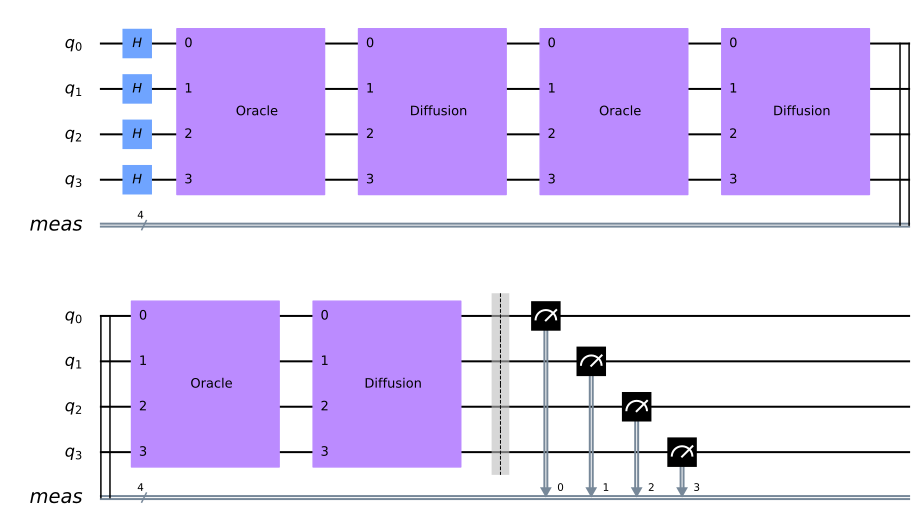

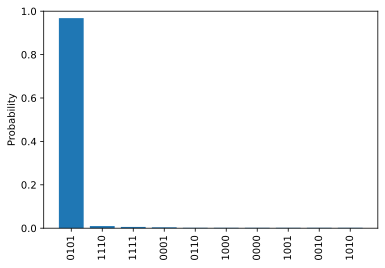

In [0]:
width = 4

circ = QuantumCircuit(width)
multi_h(circ)

for _ in range(3):
    circ.append(oracle(["0101"]), qargs=range(4)) 
    circ.append(diffusion(4), qargs=range(4)) 
    
circ.measure_all()
display(circ.draw(output="mpl", fold=17, filename="circuit"))

count = execute(circ, Aer.get_backend('qasm_simulator'), shots=500).result().get_counts()
res = [x for x in count]
res.sort(key = lambda x: count[x], reverse=True)
freqs = np.array([count[x] for x in res])
freqs = freqs / freqs.sum()

plt.bar(res, freqs)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("Probability")
plt.show()

### Small Execution

Runs the algorithm on a small chunk of atoms

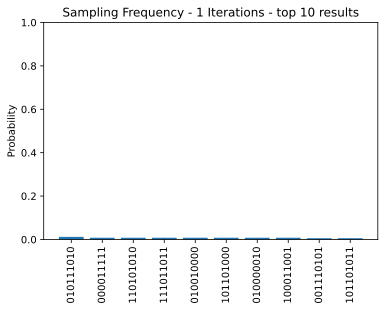

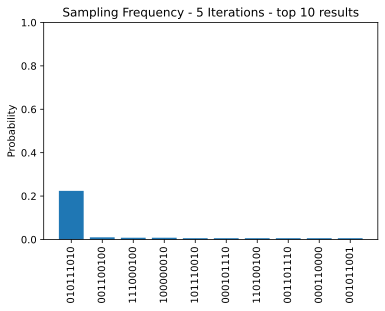

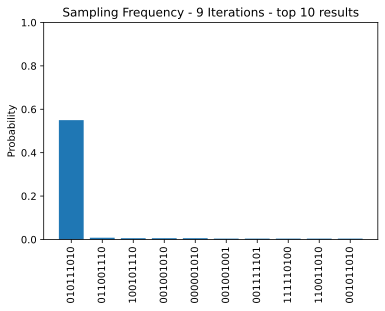

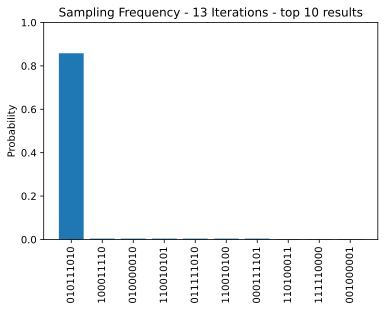

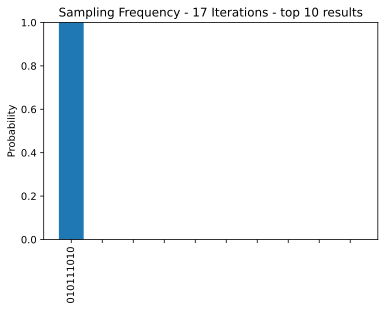

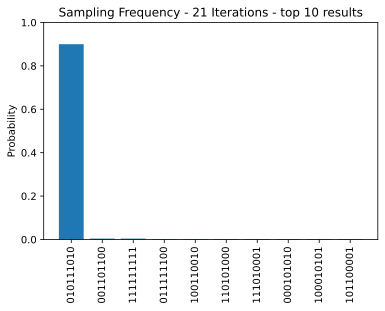

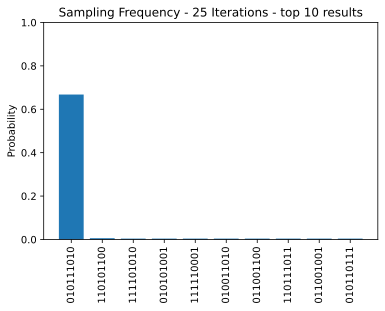

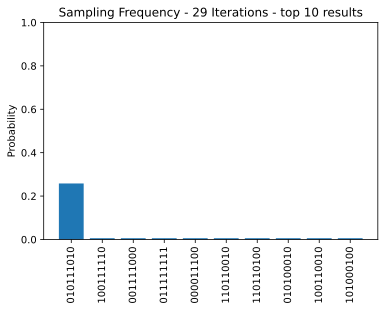

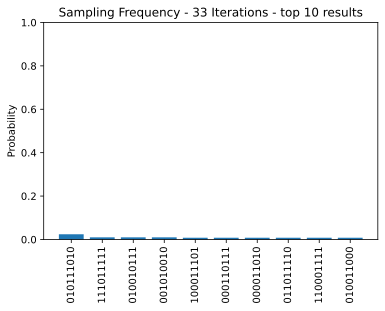

In [0]:
start = 50
end = 62

# see how the number of repeats matters
for rep in range(1, 35, 4):   
    res, freqs, accuracy = search_structures(start, end, repeats = rep)
    res = list(res)
    freqs = list(freqs)
    for k in range(len(res), 10):
        #keep the plots looking balanced
        res.append(" "*k)
        freqs.append(0)

    plt.figure()
    plt.bar(res[:10], freqs[:10])
    plt.title("Sampling Frequency - %d Iterations - top 10 results"%rep)
    plt.xticks(rotation=90)
    plt.ylim([0,1])
    plt.ylabel("Probability")
    plt.savefig("iterations-%d.png"%rep, dpi=300,bbox_inches='tight')
    plt.show()

In [0]:
distances = np.load("Backbone-distances.npy")[start:end, start:end]
bondangle = np.load("Backbone-angles.npy")[start:end]
mol = Classical_Molecule(distances, bondangle)

true_atoms = np.load("Backbone-atoms.npy")[start:end]
true_atoms = true_atoms - true_atoms[0]
pred_atoms = mol.foldstr('010111010')
pred_atoms = pred_atoms - pred_atoms[0]
pred_atoms = pred_atoms @ mol. rotate_plane(true_atoms[1], pred_atoms[1], 1)

fig = make_subplots(rows=1, cols=2, specs=[[{'is_3d': True},{'is_3d': True}]])

fig.add_trace(go.Scatter3d(x=true_atoms[:,0], y=true_atoms[:,1], z=true_atoms[:,2], name="True Structure"), row=1, col=1)
fig.add_trace(go.Scatter3d(x=pred_atoms[:,0], y=pred_atoms[:,1], z=pred_atoms[:,2], name="Reconstructed"), row=1, col=2)
fig.show()


### Piecewise Construction

Predicts small pieces at a time and then stitches them together. 

In [0]:
def invert(seq):
    s = ["1" if x == "0" else "0" for x in seq]
    return "".join(s)

In [0]:
size = 5
results = []

for a in range(0, 386, size):
    seqs, freqs, _ = search_structures(a, a+2*size+2)
    current = []
    for s,f in zip(seqs, freqs):
        if f > 0.01:
            current.append(s)
            current.append(invert(s))
    results.append(current)

merged = results[0]

for r in results[1:]:
    new = []
    for seq in r:
        for m in merged:
            if m[-size+1:] == seq[:size-1]:
                new.append(m + seq[size-1:])
    if len(new) == 0:
        break
        
    merged = new

merged = [x for x in merged if x[0] == "0"] #remove enantiomers

reference = [x for x in merged[0]]

for m in merged:
    assert len(m) == len(reference)
    for x in range(len(m)):
        if reference[x] != m[x] and reference[x] != '?':
            reference[x] = '?'
print(''.join(reference))

0010?10010111111011011111111011011011011010000011110100010100000110110111111011111011011011011011111011111100000110?11110110010?10?10010011010001010010010110001111010000?10110111011111111110010010000010010110000110010010111011000110010?1101101101011?110011010110111111011011111?11011011011111111011111001110001111011011010111011011011111111111110001110010111011011111010110?011100101


### Noisy Devices

Here I use a noise model from an actual device and see what happens.

In [0]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
real_device = provider.get_backend('ibmq_16_melbourne')
properties = real_device.properties()
noise_model = NoiseModel.from_backend(properties)


In [0]:
start = 50
end = 62

accs_noise = []
accs_no_noise = []
reps = []

for rep in range(1,34,4):
    reps.append(rep)
    seqs, freqs, accuracy = search_structures(start, end, noise_model, rep)
    accs_noise.append(accuracy)
    seqs, freqs, accuracy = search_structures(start, end, None, rep)
    accs_no_noise.append(accuracy)


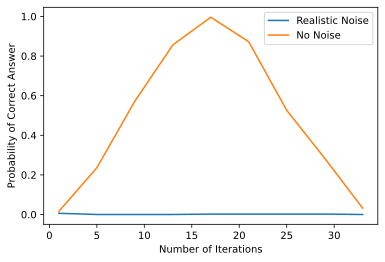

In [0]:
plt.plot(reps, accs_noise, label="Realistic Noise")
plt.plot(reps, accs_no_noise, label="No Noise")
plt.xlabel("Number of Iterations")
plt.ylabel("Probability of Correct Answer")
plt.legend()
plt.savefig("With-Noise", dpi=300)
plt.show()


### Noisy Data

Tries adding noise to the data to see what happens

In [0]:
start = 50
end = 62
distances = np.load("Backbone-distances.npy")[start:end, start:end]
bondangle = np.load("Backbone-angles.npy")[start:end]

mask = (np.abs(distances) > 1e-5)
distances  = np.maximum(distances + np.random.normal(0,.01, distances.shape) * mask, 0.1)

mol = Classical_Molecule(distances, bondangle)
width = (end-start) - 3

oracle_values = mol.classical_inversion()
print(oracle_values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning:

invalid value encountered in sqrt



[]


### Classical Gates

In order to implement the oracle in quantum gates, we need to be able to implement classical gates in quantum gates

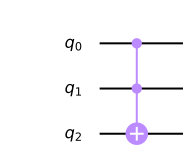

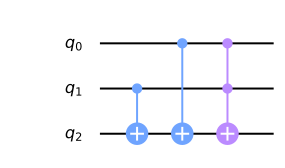

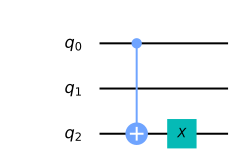

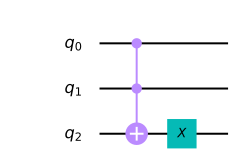

In [0]:
# and gate
circ = QuantumCircuit(3)
circ.ccx(0,1,2)
display(circ.draw(output="mpl", filename="and"))

#or gate
circ = QuantumCircuit(3)
circ.cx(1,2)
circ.cx(0,2)
circ.ccx(0,1,2)
display(circ.draw(output="mpl", filename="or"))

#not gate
circ = QuantumCircuit(3)
circ.cx(0,2)
circ.x(2)
display(circ.draw(output="mpl", filename="not"))

# nand gate
circ = QuantumCircuit(3)
circ.ccx(0,1,2)
circ.x(2)
display(circ.draw(output="mpl", filename="nand"))
